# Simple movie recommender in implicit, explicit, and cold-start settings
> Applying data cleaning, exploration, explicit KNN model, implicit ALS model, and cold-start scenario on movielens dataset

- toc: true
- badges: true
- comments: true
- categories: [Movie, Implicit, KNN]
- author: "<a href='https://github.com/topspinj/recommender-tutorial'>Jill Cates</a>"
- image:

## Import the Dependencies

In [ ]:
!pip install -q fuzzywuzzy python-Levenshtein implicit

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re 
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process
from scipy.sparse import csr_matrix
import implicit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load the Data

Let's download a small version of the [MovieLens](https://www.wikiwand.com/en/MovieLens) dataset. You can access it via the zip file url [here](https://grouplens.org/datasets/movielens/), or directly download [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip). We're working with data in `ml-latest-small.zip` and will need to add the following files to our local directory: 
- ratings.csv
- movies.csv

These are also located in the data folder inside this GitHub repository. 

Alternatively, you can access the data here: 
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

Let's load in our data and take a peek at the structure.

In [2]:
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Data Cleaning and Exploration

### Converting Genres from String Format to List 

The genres column is currently a string separated with pipes. Let's convert this into a list using the "split" function.

We want 
`"Adventure|Children|Fantasy"`
to convert to this:
`[Adventure, Children, Fantasy]`.

In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### How many movie genres are there?

We can use Python's Counter to create a dictionary containing frequency counts of each genre in our dataset.

In [ ]:
genres_counts = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genres_counts)} genre labels.")
genres_counts

There are 20 genre labels.


Counter({'(no genres listed)': 34,
         'Action': 1828,
         'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Crime': 1199,
         'Documentary': 440,
         'Drama': 4361,
         'Fantasy': 779,
         'Film-Noir': 87,
         'Horror': 978,
         'IMAX': 158,
         'Musical': 334,
         'Mystery': 573,
         'Romance': 1596,
         'Sci-Fi': 980,
         'Thriller': 1894,
         'War': 382,
         'Western': 167})

There are 20 genre labels and 19 genres that are used to describe movies in this dataset. Some movies don't have any genres, hence the label `(no genres listed)`. 

Let's remove all movies having `(no genres listed)` as its genre label. We'll also remove this from our `genre_counts` dictionary. 

In [ ]:
movies = movies[movies['genres']!='(no genres listed)']

del genres_counts['(no genres listed)']

### What are the most popular genres?

We can use `Counter`'s [most_common()](https://docs.python.org/2/library/collections.html#collections.Counter.most_common) method to get the genres with the highest movie counts.

In [ ]:
print("The 5 most common genres: \n", genres_counts.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


The top 5 genres are: `Drama`, `Comedy`, `Thriller`, `Action` and `Romance`. 

Let's also visualize genres popularity with a barplot.

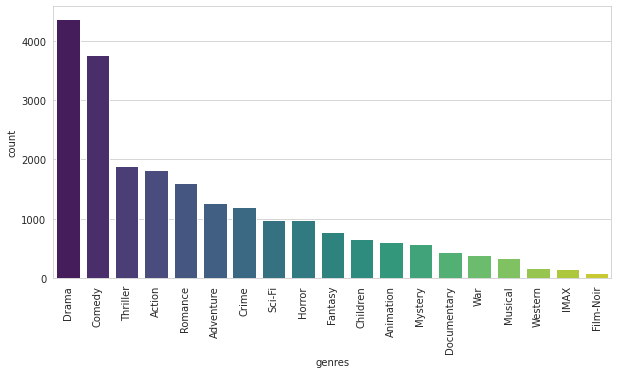

In [ ]:
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

The plot above shows that `Drama` and `Comedy` are the two most popular movie genres. The least popular movie genres are `Westerns`, `IMAX`, and `Film-Noir`.

### Parsing out year from movie title

In our dataset, movie titles currently the year of release appended to it in brackets, e.g., `"Toy Story (1995)"`. We want to use the year of a movie's release as a feature, so let's parse it out from the title string and create a new `year` column for it.

We can start with writing a function that parses out year from the title string. In the code below, `extract_year_from_title()` takes in the title and does the following:

- generates a list by splitting out each word by spaces (e.g., `["Toy", "Story", "(1995)"]`)
- gets the last element of the list (e.g., `"(1995)"`)
- if the last element has brackets surrounding it, these `()` brackets get stripped (e.g., `"1995"`)
- converts the year into an integer 

In [ ]:
def extract_year_from_title(title):
    t = title.split(' ')
    year = None
    if re.search(r'\(\d+\)', t[-1]):
        year = t[-1].strip('()')
        year = int(year)
    return year

We can test out this function with our example of `"Toy Story (1995)"`:

In [ ]:
title = "Toy Story (1995)"
year = extract_year_from_title(title)
print(f"Year of release: {year}")
print(type(year))

Year of release: 1995
<class 'int'>


Our function `extract_year_from_title()` works! It's able to successfully parse out year from the title string as shown above. We can now apply this to all titles in our `movies` dataframe using Pandas' [apply()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) method.

In [ ]:
movies['year'] = movies['title'].apply(extract_year_from_title)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0


### How many different years of release are covered in our dataset?

In [ ]:
movies['year'].nunique()

106

There are over 100 years of release in our dataset. Let's collapse this down into decades to get a general sense of when movies were released in our dataset. 

### What was the most popular decade of movie release?

Before we begin, we'll remove all movies with null year.

In [ ]:
print(f"Original number of movies: {movies['movieId'].nunique()}")

Original number of movies: 9742


In [ ]:
movies = movies[~movies['year'].isnull()]
print(f"Number of movies after removing null years: {movies['movieId'].nunique()}")

Number of movies after removing null years: 9718


We filtered out 24 movies that don't have a year of release. 

Now, there are two ways to get the decade of a year:

1. converting year to string, replacing the fourth (last) number with a 0
2. rounding year down to the nearest 10 

We'll show both implementations in the code below:

In [ ]:
x = 1995

def get_decade(year):
    year = str(year)
    decade_prefix = year[0:3] # get first 3 digits of year
    decade = f'{decade_prefix}0' # append 0 at the end
    return int(decade)

get_decade(x)

1990

In [ ]:
def round_down(year):
    return year - (year%10)

round_down(x)

1990

The two functions `get_decade()` and `round_down()` both accomplish the same thing: they both get the decade of a year.

We can apply either of these functions to all years in our `movies` dataset. We'll use `round_down()` in this example to a create a new column called `'decade'`:

In [ ]:
movies['decade'] = movies['year'].apply(round_down)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

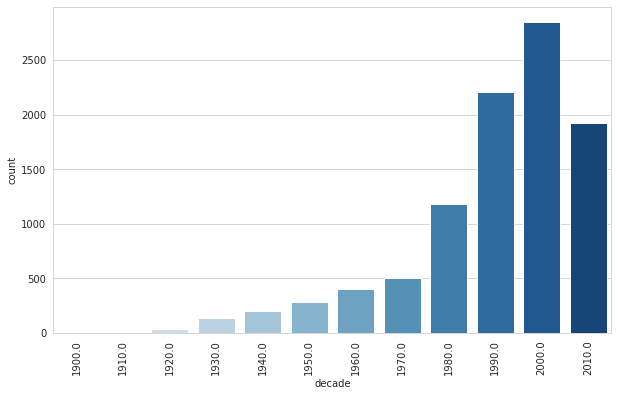

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(movies['decade'], palette='Blues')
plt.xticks(rotation=90)

As we can see from the plot above, the most common decade is the 2000s followed by the 1990s for movies in our dataset.

In [4]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


Now, let's take a look at users' rating counts. We can do this using pandas' `groupby()` and `count()` which groups the data by `userId`'s and counts the number of ratings for each userId. 

In [5]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [6]:
print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")

Mean number of ratings for a given user: 165.30.


On average, a user will have rated ~165 movies. Looks like we have some avid movie watchers in our dataset.

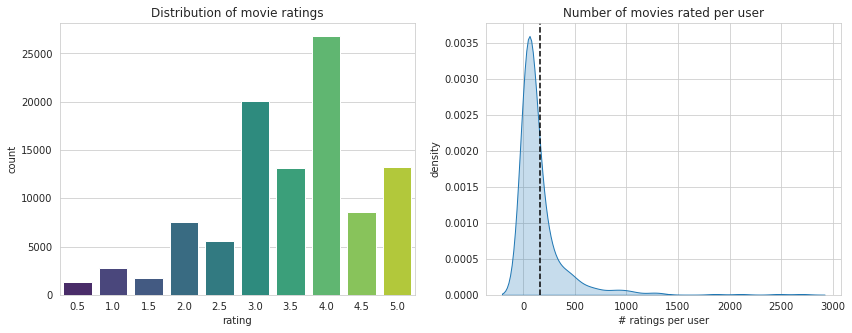

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

The most common rating is 4.0, while lower ratings such as 0.5 or 1.0 are much more rare. 

### Which movie has the lowest and highest average rating?

In [8]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


Santa with Muscles is the worst rated movie!

In [9]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


Lamerica may be the "highest" rated movie, but how many ratings does it have?

In [10]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Lamerica has only 2 ratings. A better approach for evaluating movie popularity is to look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

### Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior will be the average rating across all movies. By defintion, C represents "the typical dataset size". Let's make $C$ be the average number of ratings for a given movie.

In [11]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [12]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [13]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `Fight Club` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

Now which movies are the worst rated, according to the Bayesian average?

In [14]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like `Speed 2: Cruise Control`, `Battlefield Earth`, and `Godzilla` are the worst rated movies. `Gypsy` isn't so bad after all!

## Building an Item-Item Recommender

If you use Netflix, you will notice that there is a section titled "Because you watched Movie X", which provides recommendations for movies based on a recent movie that you've watched. This is a classic example of an item-item recommendation. We will generate item-item recommendations using a technique called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering). Let's get started! 

### Transforming the data

We will be using a technique called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to generate user recommendations. This technique is based on the assumption of "homophily" - similar users like similar things. Collaborative filtering is a type of unsupervised learning that makes predictions about the interests of a user by learning from the interests of a larger population.

The first step of collaborative filtering is to transform our data into a `user-item matrix` - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any information about the users or items to generate recommendations. 

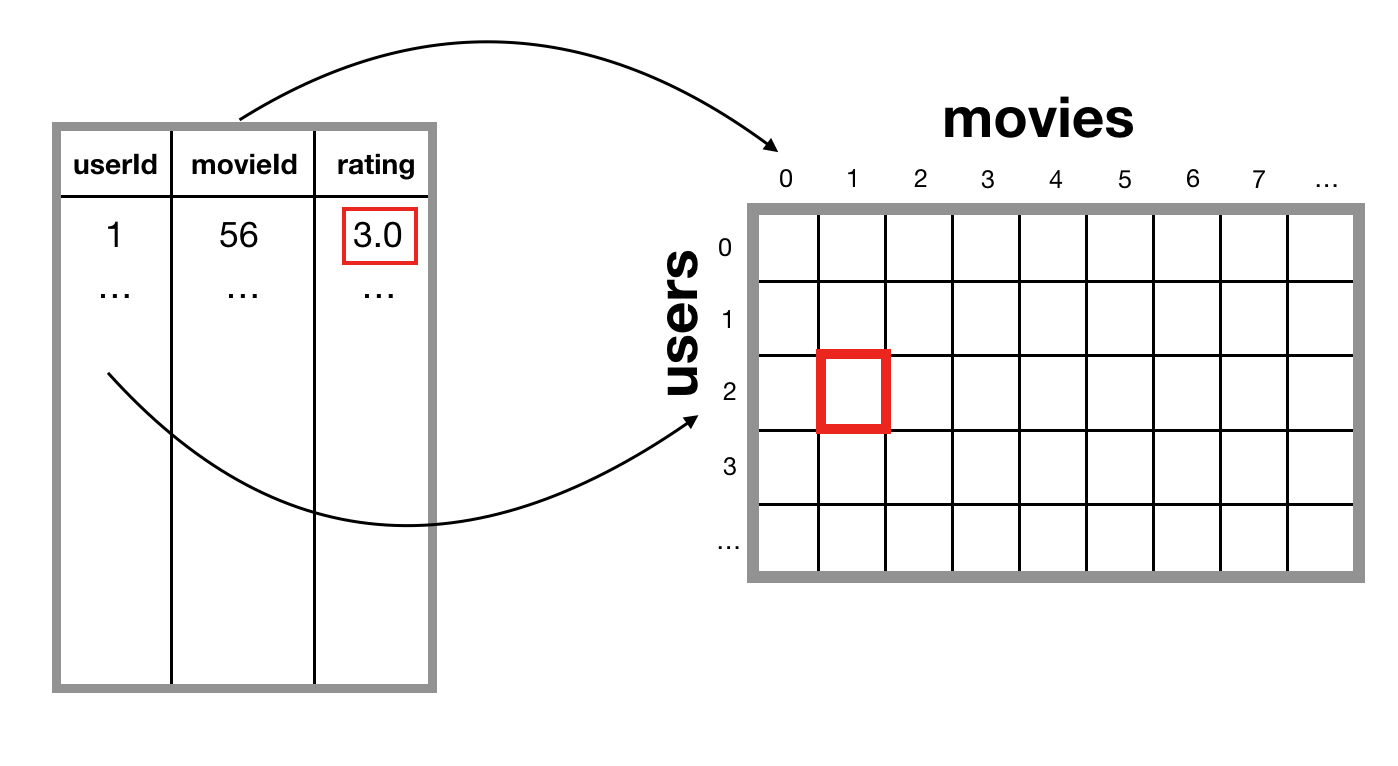

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The **X** (user-item) matrix is a [scipy.sparse.csr_matrix](scipylinkhere) which stores the data sparsely.

In [15]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [16]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below: 

$$S=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [17]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


Only 1.7% of cells in our user-item matrix are populated with ratings. But don't be discouraged by this sparsity! User-item matrices are typically very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

**Writing your matrix to a file**

We're going to save our user-item matrix for the next part of this tutorial series. Since our matrix is represented as a scipy sparse matrix, we can use the [scipy.sparse.save_npz](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.sparse.load_npz.html) method to write the matrix to a file. 

In [20]:
save_npz('user_item_matrix.npz', X)

### Finding similar movies using k-Nearest Neighbours

This approach looks for the $k$ nearest neighbours of a given movie by identifying $k$ points in the dataset that are closest to movie $m$. kNN makes use of distance metrics such as:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation 

Although difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix. 

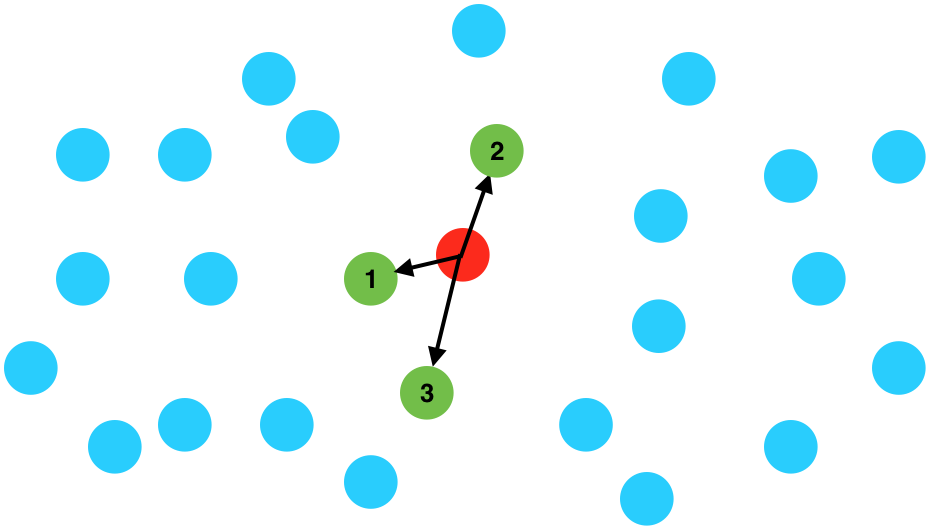

In [21]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_movies()` takes in a movieId and user-item X matrix, and outputs a list of $k$ movies that are similar to the movieId of interest. 

Let's see how it works in action. We will first create another mapper that maps `movieId` to `title` so that our results are interpretable. 

In [22]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


The results above show the 10 most similar movies to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not taken into consideration in this approach.  

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [23]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)


## Handling the Cold Start Problem with Content-Based Filtering

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no interactions get excluded from the recommendation system. This is called the "cold start" problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features. We will generate item-item recommendations using content-based filtering.

### Transforming the Data

In order to build a content-based filtering recommender, we need to set up our dataset so that rows represent movies and columns represent features (i.e., genres and decades).

First, we need to manipulate the `genres` column so that each genre is represented as a separate binary feature. "1" indicates that the movie falls under a given genre, while "0" does not. 

In [40]:
genres = list(genres_counts.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

Let's take a look at what the movie genres columns look like:

In [41]:
movies[genres].head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Great! Our genres columns are represented as binary feautres. The next step is to wrangle our `decade` column so that each decade has its own column. We can do this using pandas' [get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function, which works by creating a categorical variable into binary variables.

In [42]:
movie_decades = pd.get_dummies(movies['decade'])
movie_decades.head()

,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0


Now, let's create a new `movie_features` dataframe by combining our genres features and decade features. We can do this using pandas' [concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) function which concatenates (appends) genres and decades into a single dataframe.

In [43]:
movie_features = pd.concat([movies[genres], movie_decades], axis=1)
movie_features.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Our `movie_features` dataframe is ready. The next step is to start building our recommender. 

### Building a "Similar Movies" Recommender Using Cosine Similarity

We're going to build our item-item recommender using a similarity metric called [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). 

Cosine similarity looks at the cosine angle between two vectors (e.g., $A$ and $B$). The smaller the cosine angle, the higher the degree of similarity between $A$ and $B$. You can calculate the similarity between $A$ and $B$ with this equation:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

In this tutorial, we're going to use scikit-learn's cosine similarity [function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to generate a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$. With this cosine similarity matrix, we'll be able to extract movies that are most similar to the movie of interest.

In [44]:
cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Dimensions of our movie features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our movie features cosine similarity matrix: (9718, 9718)


As expected, after passing the `movie_features` dataframe into the `cosine_similarity()` function, we get a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$.

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.

### Let's create a movie finder function

Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset. 

In our dataset, Jumanji is actually listed as `'Jumanji (1995)'`. If we misspell Jumanji or forget to include its year of release, our recommender won't be able to identify which movie we're interested in.  

To make our recommender more user-friendly, we can use a Python package called [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) which will find the most similar title to a string that you pass in. Let's create a function called `movie_finder()` which take advantage of `fuzzywuzzy`'s string matching algorithm to get the most similar title to a user-inputted string. 

In [50]:
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

Let's test this out with our Jumanji example. 

In [51]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

To get relevant recommendations for Jumanji, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix. 

Let's create a movie index dictionary called `movie_idx` where the keys are movie titles and values are movie indices:

In [52]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
idx

1

Using this handy `movie_idx` dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [53]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

`similar_movies` is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse `movie_idx` mapper or using `iloc` on the title column of the `movies` dataframe.

In [54]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
1618    NeverEnding Story II: The Next Chapter, The (1...
8719                   The Cave of the Golden Rose (1991)
9565                            Gulliver's Travels (1996)
1357                                Borrowers, The (1997)
1565                                     Tall Tale (1995)
2539                We're Back! A Dinosaur's Story (1993)
5624    Kirikou and the Sorceress (Kirikou et la sorci...
5975    Asterix & Obelix vs. Caesar (Astérix et Obélix...
Name: title, dtype: object

Cool! These recommendations seem pretty relevant and similar to Jumanji. The first 5 movies are family-friendly films from the 90s. 

We can test our recommender further with other movie titles. For your convenience, I've packaged the steps into a single function which takes in the movie title of interest and number of recommendations. 

In [55]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Recommendations for {title}:")
    print(movies['title'].iloc[similar_movies])

In [56]:
get_content_based_recommendations('aladin', 5)

Recommendations for Aladdin (1992):
1177                                      Hercules (1997)
95                          Muppet Treasure Island (1996)
673     Land Before Time III: The Time of the Great Gi...
1757                                 Bug's Life, A (1998)
3727                Ferngully: The Last Rainforest (1992)
Name: title, dtype: object


## Building a Recommender System with Implicit Feedback

In this section, we will build an implicit feedback recommender system using the [implicit](https://github.com/benfred/implicit) package.

What is implicit feedback, exactly? Let's revisit collaborative filtering. In [Part 1](https://github.com/topspinj/recommender-tutorial/blob/master/part-1-item-item-recommender.ipynb), we learned that [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) is based on the assumption that `similar users like similar things`. The user-item matrix, or "utility matrix", is the foundation of collaborative filtering. In the utility matrix, rows represent users and columns represent items. 

The cells of the matrix are populated by a given user's degree of preference towards an item, which can come in the form of:

1. **explicit feedback:** direct feedback towards an item (e.g., movie ratings which we explored in [Part 1](https://github.com/topspinj/recommender-tutorial/blob/master/part-1-item-item-recommender.ipynb))
2. **implicit feedback:** indirect behaviour towards an item (e.g., purchase history, browsing history, search behaviour)

Implicit feedback makes assumptions about a user's preference based on their actions towards items. Let's take Netflix for example. If you binge-watch a show and blaze through all seasons in a week, there's a high chance that you like that show. However, if you start watching a series and stop halfway through the first episode, there's suspicion to believe that you probably don't like that show. 

In [59]:
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")

For this implicit feedback tutorial, we'll treat movie ratings as the number of times that a user watched a movie. For example, if Jane (a user in our database) gave `Batman` a rating of 1 and `Legally Blonde` a rating of 5, we'll assume that Jane watched Batman one time and Legally Blonde five times. 

### Transforming the Data

We need to transform the `ratings` dataframe into a user-item matrix where rows represent users and columns represent movies. The cells of this matrix will be populated with implicit feedback: in this case, the number of times a user watched a movie. 

The `create_X()` function outputs a sparse matrix **X** with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The **X** (user-item) matrix is a [scipy.sparse.csr_matrix](scipylinkhere) which stores the data sparsely.

In [60]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [61]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

### Creating Movie Title Mappers

We need to interpret a movie title from its index in the user-item matrix and vice versa. Let's create 2 helper functions that make this interpretation easy:

- `get_movie_index()` - converts a movie title to movie index
    - Note that this function uses [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy)'s string matching to get the approximate movie title match based on the string that gets passed in. This means that you don't need to know the exact spelling and formatting of the title to get the corresponding movie index.
- `get_movie_title()` - converts a movie index to movie title

In [62]:
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

movie_title_mapper = dict(zip(movies['title'], movies['movieId']))
movie_title_inv_mapper = dict(zip(movies['movieId'], movies['title']))

def get_movie_index(title):
    fuzzy_title = movie_finder(title)
    movie_id = movie_title_mapper[fuzzy_title]
    movie_idx = movie_mapper[movie_id]
    return movie_idx

def get_movie_title(movie_idx): 
    movie_id = movie_inv_mapper[movie_idx]
    title = movie_title_inv_mapper[movie_id]
    return title 

It's time to test it out! Let's get the movie index of `Legally Blonde`. 

In [63]:
get_movie_index('Legally Blonde')

3282

Let's pass this index value into `get_movie_title()`. We're expecting Legally Blonde to get returned.

In [64]:
get_movie_title(3282)

'Legally Blonde (2001)'

Great! These helper functions will be useful when we want to interpret our recommender results.

### Building Our Implicit Feedback Recommender Model


We've transformed and prepared our data so that we can start creating our recommender model.

The [implicit](https://github.com/benfred/implicit) package is built around a linear algebra technique called [matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)), which can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. Matrix factorization is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.

$$X_{mn} \approx P_{mk} \times Q_{nk}^T = \hat{X}$$

<img src="images/matrix-factorization.png" width="60%"/>

In traditional matrix factorization, such as SVD, we would attempt to solve the factorization at once which can be very computationally expensive. As a more practical alternative, we can use a technique called `Alternating Least Squares (ALS)` instead. With ALS, we solve for one factor matrix at a time:

- Step 1: hold user-factor matrix fixed and solve for the item-factor matrix
- Step 2: hold item-factor matrix fixed and solve for the user-item matrix

We alternate between Step 1 and 2 above, until the dot product of the item-factor matrix and user-item matrix is approximately equal to the original X (user-item) matrix. This approach is less computationally expensive and can be run in parallel.

The [implicit](https://github.com/benfred/implicit) package implements matrix factorization using Alternating Least Squares (see docs [here](https://implicit.readthedocs.io/en/latest/als.html)). Let's initiate the model using the `AlternatingLeastSquares` class.

In [75]:
model = implicit.als.AlternatingLeastSquares(factors=50, use_gpu=False)

This model comes with a couple of hyperparameters that can be tuned to generate optimal results:

- factors ($k$): number of latent factors,
- regularization ($\lambda$): prevents the model from overfitting during training

In this tutorial, we'll set $k = 50$ and $\lambda = 0.01$ (the default). In a real-world scenario, I highly recommend tuning these hyperparameters before generating recommendations to generate optimal results.

The next step is to fit our model with our user-item matrix. 

In [76]:
model.fit(X)

Now, let's test out the model's recommendations. We can use the model's `similar_items()` method which returns the most relevant movies of a given movie. We can use our helpful `get_movie_index()` function to get the movie index of the movie that we're interested in.

In [67]:
movie_of_interest = 'forrest gump'

movie_index = get_movie_index(movie_of_interest)
related = model.similar_items(movie_index)
related

[(314, 1.0),
 (4014, 0.8585007),
 (7375, 0.85635275),
 (5969, 0.8484588),
 (4043, 0.8481082),
 (678, 0.8473785),
 (9265, 0.8454406),
 (7647, 0.8449428),
 (6341, 0.8441848),
 (3306, 0.84347767)]

The output of `similar_items()` is not user-friendly. We'll need to use our `get_movie_title()` function to interpret what our results are. 

In [68]:
print(f"Because you watched {movie_finder(movie_of_interest)}...")
for r in related:
    recommended_title = get_movie_title(r[0])
    if recommended_title != movie_finder(movie_of_interest):
        print(recommended_title)

Because you watched Forrest Gump (1994)...
Auto Focus (2002)
Two Escobars, The (2010)
Cry_Wolf (a.k.a. Cry Wolf) (2005)
Happy Birthday to Me (1981)
Wild Reeds (Les roseaux sauvages) (1994)
Kicking Off (2016)
Help, The (2011)
Blood Diamond (2006)
Blob, The (1988)


When we treat user ratings as implicit feedback, the results look pretty good! You can test out other movies by changing the `movie_of_interest` variable.

### Generating User-Item Recommendations

A cool feature of [implicit](https://github.com/benfred/implicit) is that you can pull personalized recommendations for a given user. Let's test it out on a user in our dataset.

In [69]:
user_id = 95

In [70]:
user_ratings = ratings[ratings['userId']==user_id].merge(movies[['movieId', 'title']])
user_ratings = user_ratings.sort_values('rating', ascending=False)
print(f"Number of movies rated by user {user_id}: {user_ratings['movieId'].nunique()}")

Number of movies rated by user 95: 168


User 95 watched 168 movies. Their highest rated movies are below:

In [71]:
user_ratings = ratings[ratings['userId']==user_id].merge(movies[['movieId', 'title']])
user_ratings = user_ratings.sort_values('rating', ascending=False)
top_5 = user_ratings.head()
top_5

,userId,movieId,rating,timestamp,title
24,95,1089,5.0,1048382826,Reservoir Dogs (1992)
34,95,1221,5.0,1043340018,"Godfather: Part II, The (1974)"
83,95,3019,5.0,1043340112,Drugstore Cowboy (1989)
26,95,1175,5.0,1105400882,Delicatessen (1991)
27,95,1196,5.0,1043340018,Star Wars: Episode V - The Empire Strikes Back...


Their lowest rated movies:

In [72]:
bottom_5 = user_ratings[user_ratings['rating']<3].tail()
bottom_5

,userId,movieId,rating,timestamp,title
93,95,3690,2.0,1043339908,Porky's Revenge (1985)
122,95,5283,2.0,1043339957,National Lampoon's Van Wilder (2002)
100,95,4015,2.0,1043339957,"Dude, Where's My Car? (2000)"
164,95,7373,1.0,1105401093,Hellboy (2004)
109,95,4732,1.0,1043339283,Bubble Boy (2001)


Based on their preferences above, we can get a sense that user 95 likes action and crime movies from the early 1990's over light-hearted American comedies from the early 2000's. Let's see what recommendations our model will generate for user 95.

We'll use the `recommend()` method, which takes in the user index of interest and transposed user-item matrix. 

In [73]:
X_t = X.T.tocsr()

user_idx = user_mapper[user_id]
recommendations = model.recommend(user_idx, X_t)
recommendations

[(1698, 0.0020483332),
 (8377, 0.0020200226),
 (272, 0.0019920522),
 (6896, 0.0019785003),
 (6011, 0.001972728),
 (5101, 0.001972528),
 (9255, 0.0019725084),
 (9406, 0.001967933),
 (1898, 0.0019679233),
 (5318, 0.0019655072)]

We can't interpret the results as is since movies are represented by their index. We'll have to loop over the list of recommendations and get the movie title for each movie index. 

In [74]:
for r in recommendations:
    recommended_title = get_movie_title(r[0])
    print(recommended_title)

Fiendish Plot of Dr. Fu Manchu, The (1980)
Captain America: The Winter Soldier (2014)
Swan Princess, The (1994)
Hunger (2008)
Brokeback Mountain (2005)
Indestructible Man (1956)
Barbershop: The Next Cut (2016)
HyperNormalisation (2016)
Rollercoaster (1977)
Mr. 3000 (2004)


User 95's recommendations consist of action, crime, and thrillers. None of their recommendations are comedies. 